In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

In [2]:
dataset = pd.read_csv(filepath_or_buffer='../all_data.csv', index_col=0)
FEATURES_INDEX = np.arange(2)
LABELS_INDEX = 2
BATCH_SIZE = int(0.6*len(dataset))
LOSS_THRESHOLD = 1e-6
dataset.head()
dataset=np.array(dataset)

spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True)
spam_dataset.reset_index(drop=True, inplace=True)
nonspam_dataset.tail()

rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam)
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

In [3]:
learn_dataset = dataset[0: int(0.6*len(dataset))]
valid_dataset = dataset[int(0.6*len(dataset)): int(0.9*len(dataset))]
test_dataset = dataset[int(0.9*len(dataset)): len(dataset)]
len(dataset)

7775

In [4]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [5]:
learn_dataloader = DataLoader(learn_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.tanh(self.lin3(x))
        x = self.lin4(x)
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
is_load = False
if is_load:
    net.load_state_dict(torch.load('gd/net_params.pkl'))

In [8]:
#Инициализация весов
STD = [(2/(2+10+1))**(1/2), (2/(10+10+1))**(1/2), (32/(10+5+1))**(1/2), (32/(5+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
tensor([ 0.1043, -0.4861,  0.2494, -0.4144,  0.1533,  0.0123, -0.3635,
         0.5452,  0.0867, -0.1032])


In [9]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([ 0.1043, -0.4861,  0.2494, -0.4144,  0.1533,  0.0123, -0.3635,
         0.5452,  0.0867, -0.1032])

In [10]:
criterion = nn.MSELoss(size_average=True)

In [11]:
%%time
learn_loss_by_lr = []
valid_loss_by_lr = []
test_loss_by_lr = []
epoch_loss_by_lr = []
lr_list = [0.1, 0.01, 0.001, 0.0001, 0.00001]

for lr in lr_list:
    optimizer = optim.SGD(net.parameters(), lr=lr)
    
    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)
    
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []
    
    for epoch in range(5000):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))
        
        #критерий останова
        if (epoch > 10) and (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lr: ', lr, ' breaked on epoch: ', epoch, '\n')
            break
            
        if epoch % 100 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))
                
            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))
                
    learn_loss_by_lr.append(learn_epoch_loss)
    valid_loss_by_lr.append(valid_epoch_loss)
    test_loss_by_lr.append(test_epoch_loss)
    epoch_loss_by_lr.append(epoch_list)

9.685754776000977e-07
lr:  0.01  breaked on epoch:  468 

-9.5367431640625e-07
lr:  0.001  breaked on epoch:  2804 

CPU times: user 14min 18s, sys: 16.1 s, total: 14min 34s
Wall time: 11min 38s


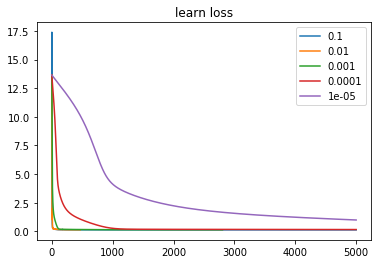

In [12]:
#learn
for num, i in enumerate(lr_list):
    plt.plot(learn_loss_by_lr[num], label=str(i))
plt.title('learn loss')
plt.legend()
plt.savefig('gd/learn_loss.png', bbox_inches='tight')

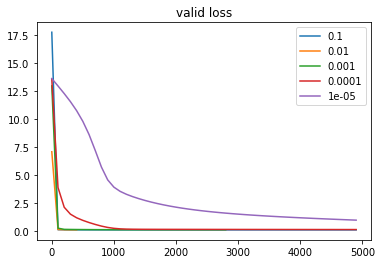

In [13]:
#valid
for num, i in enumerate(lr_list):
    plt.plot(epoch_loss_by_lr[num], valid_loss_by_lr[num], label=str(i))
plt.title('valid loss')
plt.legend()
plt.savefig('gd/valid_loss.png', bbox_inches='tight')

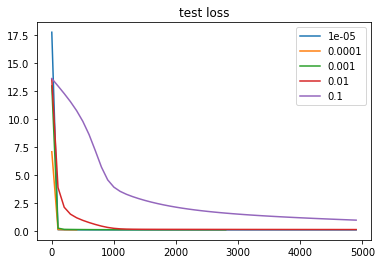

In [32]:
#test
for num, i in enumerate(lr_list):
    plt.plot(epoch_loss_by_lr[num], test_loss_by_lr[num], label=str(i))
plt.title('test loss')
plt.legend()
plt.savefig('gd/test_loss.png', bbox_inches='tight')

In [16]:
for i in range(5):
    print((learn_loss_by_lr[i])[-1])

0.12355811893939972
0.13391214609146118
0.13318787515163422
0.1564333736896515
0.9905683994293213


In [15]:
for i in range(5):
    print((test_loss_by_lr[i])[-1])

0.12181378155946732
0.13293418288230896
0.1328890323638916
0.1546892374753952
0.9948427677154541


In [31]:
len(test_loss_by_lr[3])

[[17.78319549560547,
  0.14223937690258026,
  0.1336154043674469,
  0.13062991201877594,
  0.1288825124502182,
  0.12794463336467743,
  0.12725363671779633,
  0.1266968995332718,
  0.12621799111366272,
  0.12577414512634277,
  0.1253679394721985,
  0.12502115964889526,
  0.1247463971376419,
  0.12454146146774292,
  0.12439167499542236,
  0.12428039312362671,
  0.12419062852859497,
  0.12410814315080643,
  0.12401939183473587,
  0.12391356378793716,
  0.12378872185945511,
  0.12365378439426422,
  0.12352518737316132,
  0.12341469526290894,
  0.12332428246736526,
  0.12324929237365723,
  0.12318366765975952,
  0.12312330305576324,
  0.12306421250104904,
  0.12300466001033783,
  0.12294422835111618,
  0.12288214266300201,
  0.12281826883554459,
  0.12275311350822449,
  0.12268651276826859,
  0.12261931598186493,
  0.122551828622818,
  0.12248453497886658,
  0.12241766601800919,
  0.12235160917043686,
  0.1222868263721466,
  0.12222414463758469,
  0.12216326594352722,
  0.12210509926080704